In [ ]:
# import simulation
import os
import sys
root_path = os.path.abspath("../..")
em_simulator_path = root_path
print(em_simulator_path)
sys.path.append(em_simulator_path)

import em_simulation as sim

/Users/songjaesung/Desktop/QDLAB/githubs/EM_simulation_open/dataset-based-eme
failed to load lumerical api (Dataset acquisition) (Lumerical Version)
failed to load lumerical api (Dataset acquisition)(Ansys version)
failed to load lumerical api (Dataset acquisition) (Lumerical Version)
failed to load lumerical api (Dataset acquisition) (Ansys version)


2025-07-09 15:35:48,215	INFO worker.py:1786 -- Started a local Ray instance.
2025-07-09 15:35:48,240	INFO packaging.py:531 -- Creating a file package for local directory '/Users/songjaesung/Desktop/QDLAB/githubs/EM_simulation_open/dataset-based-eme'.
2025-07-09 15:35:48,253	INFO packaging.py:359 -- Pushing file package 'gcs://_ray_pkg_9d8e67d64cc4a7a3.zip' (0.30MiB) to Ray cluster...
2025-07-09 15:35:48,255	INFO packaging.py:372 -- Successfully pushed file package 'gcs://_ray_pkg_9d8e67d64cc4a7a3.zip'.


(pid=56492) failed to load lumerical api (Dataset acquisition) (Lumerical Version)
(pid=56492) failed to load lumerical api (Dataset acquisition)(Ansys version)
(pid=56492) failed to load lumerical api (Dataset acquisition) (Lumerical Version)
(pid=56492) failed to load lumerical api (Dataset acquisition) (Ansys version)


In [2]:
import math
import random
import numpy as np
import operator

from scipy.integrate import trapezoid as trapz
from scipy.integrate import cumulative_trapezoid as cumtrapz

from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

from deap import base, creator, tools, benchmarks

In [3]:
# the dataset folder path
dataset_folder = root_path + "/sample_datasets/Si_rectangular_single_waveguide"
Si_dataset = sim.DataUpdater(dataset_folder, is_testmode=True)

## bend generation code (Bezier Spline parameterized)

In [4]:
def bezier_curve(points, num_points=100):
    n = len(points) - 1
    t = np.linspace(0, 1, num_points)
    curve = np.zeros((num_points, 2))
    for i in range(num_points):
        for j in range(n + 1):
            # bernstein_poly = (np.math.factorial(n) / (np.math.factorial(j) * np.math.factorial(n - j))) * (t[i] ** j) * ((1 - t[i]) ** (n - j))
            bernstein_poly = (math.factorial(n) / (math.factorial(j) * math.factorial(n - j))) * (t[i] ** j) * ((1 - t[i]) ** (n - j))
            curve[i] += bernstein_poly * points[j]
    return curve

In [5]:
def find_angle_list(prop_len_list, curv_list):
    angle_list = cumtrapz(curv_list, prop_len_list, initial=0)
    return angle_list

def find_bend_angle(prop_len_list, curv_list):
    angle_list = find_angle_list(prop_len_list, curv_list)
    return angle_list[-1]

def find_Rx(prop_len_list, curv_list):
    angle_list = find_angle_list(prop_len_list, curv_list)
    integrand = np.cos(angle_list)
    Rx = trapz(integrand, prop_len_list)
    return Rx

def find_Ry(prop_len_list, curv_list):
    angle_list = find_angle_list(prop_len_list, curv_list)
    integrand = np.sin(angle_list)
    Ry = trapz(integrand, prop_len_list)
    return Ry


def apply_angle_and_zfactor(prop_len_list, curv_list, z_scale_factor, bend_angle):
    new_prop_len_list = z_scale_factor * prop_len_list
    bend_angle_temp = find_bend_angle(new_prop_len_list, curv_list)

    c_scale_factor = np.where(bend_angle_temp, bend_angle/bend_angle_temp, bend_angle_temp)
    new_curv_list = c_scale_factor * curv_list

    return new_prop_len_list, new_curv_list


def apply_Ry(prop_len_list, curv_list, Ry):
    Ry_temp = find_Ry(prop_len_list, curv_list)
    cy = Ry / Ry_temp
    angle_list = find_angle_list(prop_len_list, curv_list)

    integrand = np.sqrt(np.cos(angle_list)**2 + (cy**2) * np.sin(angle_list)**2)
    new_prop_len_list = cumtrapz(integrand, prop_len_list, initial=0)
    new_curv_denom = (np.cos(angle_list)**2 + (cy**2)*np.sin(angle_list)**2)**(3/2)
    new_curv_nom = cy * curv_list
    new_curv_list = new_curv_nom / new_curv_denom

    return new_prop_len_list, new_curv_list
    

def apply_angle_and_RxRy(prop_len_list, curv_list, Rx, Ry, bend_angle = np.pi/2):
    error_tolerance = 1e-5
    max_trial_num = 500

    dummy_high_num = 1e5

    z_scale_max = dummy_high_num
    z_scale_min = 0

    error = dummy_high_num
    trial_num = 0
    z_scale_temp = 1

    prop_len_temp, curv_temp = apply_angle_and_zfactor(prop_len_list, curv_list, z_scale_temp, bend_angle)
    Rx_temp = find_Rx(prop_len_temp, curv_temp)

    while error > error_tolerance and trial_num < max_trial_num:
        if z_scale_temp > z_scale_max or z_scale_temp < z_scale_min:
            print("z_scale_temp is out of range")
            return

        if Rx_temp > Rx:
            z_scale_max = z_scale_temp
            z_scale_temp = (z_scale_min + z_scale_temp)/2
        elif Rx_temp < Rx:
            z_scale_min = z_scale_temp
            z_scale_temp = (z_scale_max + z_scale_temp)/2
        
        prop_len_temp, curv_temp = apply_angle_and_zfactor(prop_len_list, curv_list, z_scale_temp, bend_angle)
        Rx_temp = find_Rx(prop_len_temp, curv_temp)
        
        error = np.abs(Rx - Rx_temp)/Rx
        trial_num += 1
        
    new_prop_len_list, new_curv_list = apply_angle_and_zfactor(prop_len_list, curv_list, z_scale_temp, bend_angle)

    new_prop_len_list, new_curv_list = apply_Ry(new_prop_len_list, new_curv_list, Ry)

    return new_prop_len_list, new_curv_list, error

In [6]:
def generate_smooth_bend(input_width, output_width, min_width, max_width, width_parameters, curvature_parameters, Rx, Ry, resolution = 100):
    """
    Reff in m
    width_parameters: parameters within 0 and 1
    curvature_parameters: parameters within 0 and 1
    width_parameters & curvature_parameters: control point paramters of bend (bend is not symmetric)
    """
    if len(width_parameters) != len(curvature_parameters):
        print("number of width control points and curvature control points should be same")
        return
    num_control_pt = len(width_parameters)

    xs = np.linspace(0, 1, num_control_pt+2)
    width_variance = list(min_width + np.array(width_parameters)*(max_width-min_width))
    widths_ctr_ys = np.array([input_width] + width_variance + [output_width])
    curvature_ctr_ys = np.array([0] + list(curvature_parameters) + [0])
    width_ctr_pts = np.array(list(zip(xs, widths_ctr_ys)))
    curvature_ctr_pts = np.array(list(zip(xs, curvature_ctr_ys)))

    widths = bezier_curve(width_ctr_pts, num_points=resolution)[:,1]
    curvatures = bezier_curve(curvature_ctr_pts, num_points=resolution)[:,1]


    prop_lens = np.linspace(0, 1, resolution)

    prop_lens, curvatures, error = apply_angle_and_RxRy(prop_lens, curvatures, Rx, Ry)

    singlebend = sim.SingleCustomBend(Si_dataset, prop_lens, widths, curvatures, input_angle=0, verbose=False, resolution=5000)

    return singlebend

### Functions for PSO

In [7]:
def evaluate(individual):
    # first half individual is topwidth parameters and last half individual is curvature parameters
    # evaluate quality of mode keeping
    input_width = 2e-6
    output_width = 2e-6
    min_width = 2e-6
    max_width = 3e-6
    param_length = len(individual)//2
    width_params = individual[:param_length]
    curvature_params = individual[param_length:]
    Rx = 20e-6
    Ry = 20e-6
    
    def subtask(width_in, width_out, width_min, width_max, widths_pts, curvatures_pts):
        smooth_bend = generate_smooth_bend(width_in, width_out, width_min, width_max, widths_pts, curvatures_pts, Rx, Ry, resolution = 100)
        smooth_bend.calc_output_data()
        smooth_bend_eme = sim.EME(smooth_bend, force_unitary=1)

        mode1_input = [1,0,0,0,0,0,0,0,0,0]
        mode2_input = [0,1,0,0,0,0,0,0,0,0]

        smooth_bend_eme_runner = sim.Runner(smooth_bend_eme)

        mode1in_output = smooth_bend_eme_runner.propagate_lumped_smatrix(mode1_input)
        mode2in_output = smooth_bend_eme_runner.propagate_lumped_smatrix(mode2_input)

        mode1inmode1out = np.abs(mode1in_output[0])**2
        mode1inmode2out = np.abs(mode1in_output[1])**2
        mode2inmode1out = np.abs(mode2in_output[0])**2
        mode2inmode2out = np.abs(mode2in_output[1])**2

        a = np.abs(0.5-mode1inmode1out)
        b = np.abs(0.5-mode1inmode2out)
        c = np.abs(0.5-mode2inmode1out)
        d = np.abs(0.5-mode2inmode2out)

        result = a + b + c + d
        return result
    
    performance = subtask(input_width, output_width, min_width, max_width, width_params, curvature_params)

    result = performance

    return result, performance

In [8]:
creator.create("FitnessMin", base.Fitness, weights=(1.0,))
creator.create("Particle", list, fitness=creator.FitnessMin, speed=list, smin1=None, smax1=None, smi2n=None, smax2=None, best=None)

In [9]:
def generate(size, pmin1, pmax1, pmin2, pmax2, smin1, smax1, smin2, smax2):
    # first half individual is topwidth parameters and last half individual is curvature parameters
    # parameter1 is for width, parameter2 is for curvature
    part = creator.Particle([random.uniform(pmin1, pmax1) for _ in range(size)] + [random.uniform(pmin2, pmax2) for _ in range(size)]) 
    part.speed = [random.uniform(smin1, smax1) for _ in range(size)] + [random.uniform(smin2, smax2) for _ in range(size)]
    part.smin1 = smin1
    part.smax1 = smax1
    part.smin2 = smin2
    part.smax2 = smax2
    return part

In [10]:
def modify_seed(seed, p):
    seed = np.array(seed)
    random_values = np.random.uniform(-p, p, size=seed.shape)
    modified_seed = seed + random_values
    modified_seed = np.clip(modified_seed, 0, 1)
    
    return modified_seed

In [11]:
def generate_variant_from_seed(width_seed, curvature_seed, width_var, curvature_var, smin1, smax1, smin2, smax2):
    """
    smin1: width optimization minimum speed
    smax1: width optimization maximum speed
    smin2: curvature optimization minimum speed
    smax2: curvature optimization maximum speed
    """
    modified_width = modify_seed(width_seed, width_var)
    modified_curvature = modify_seed(curvature_seed, curvature_var)
    modified_tot_params = list(modified_width) + list(modified_curvature)
    part = creator.Particle(modified_tot_params)

    part.speed = [random.uniform(smin1, smax1) for _ in range(len(width_seed))] + [random.uniform(smin2, smax2) for _ in range(len(curvature_seed))]
    part.smin1 = smin1
    part.smax1 = smax1
    part.smin2 = smin2
    part.smax2 = smax2

    return part

In [12]:
def updateParticle(part, best, phi11, phi12, phi21, phi22, width_size=None, inertia1 = 0.7, inertia2 = 0.7):
    """
    phi11: local width optimization speed
    phi12: global width optimization speed
    phi21: local curvature optimization speed
    phi22: global curvature optimization speed
    """
    if not width_size: width_size = int(len(part)/2)
    curvature_size = len(part) - width_size

    u11 = (random.uniform(0, phi11) for _ in range(len(part)))
    u12 = (random.uniform(0, phi12) for _ in range(len(part)))
    u21 = (random.uniform(0, phi21) for _ in range(len(part)))
    u22 = (random.uniform(0, phi22) for _ in range(len(part)))
    v_u11 = map(operator.mul, u11, map(operator.sub, part.best, part))
    v_u12 = map(operator.mul, u12, map(operator.sub, best, part))
    v_u21 = map(operator.mul, u21, map(operator.sub, part.best, part))
    v_u22 = map(operator.mul, u22, map(operator.sub, best, part))

    speed1 = list(map(operator.add, inertia1 * np.array(part.speed), map(operator.add, v_u11, v_u12)))
    speed2 = list(map(operator.add, inertia2 * np.array(part.speed), map(operator.add, v_u21, v_u22)))

    speed1[width_size:] = np.zeros(width_size)
    speed2[:width_size] = np.zeros(curvature_size)
    
    for i, speed in enumerate(speed1):
        if abs(speed) < part.smin1:
            speed1[i] = math.copysign(part.smin1, speed)
        elif abs(speed) > part.smax1:
            speed1[i] = math.copysign(part.smax1, speed)

    for i, speed in enumerate(speed2):
        if abs(speed) < part.smin2:
            speed2[i] = math.copysign(part.smin2, speed)
        elif abs(speed) > part.smax2:
            speed2[i] = math.copysign(part.smax2, speed)

    speed_tot = np.array(speed1) + np.array(speed2) # concatenate the width speed and curvature speed

    part.speed = speed_tot

    part_temp = list(map(operator.add, part, part.speed))
    part[:] = np.clip(part_temp, 0, 1)

In [13]:
toolbox = base.Toolbox()

num_section = 15


toolbox.register("particle", generate, size=num_section, pmin1=0, pmax1=1, pmin2=0, pmax2=1, smin1=0, smax1=0.05, smin2=0, smax2=0.05)
toolbox.register("population", tools.initRepeat, list, toolbox.particle)
toolbox.register("update", updateParticle, phi11=1, phi12=1,  phi21=1, phi22=1)
toolbox.register("update_width", updateParticle, phi11=1, phi12=1,  phi21=0, phi22=0, inertia2 = 0)
toolbox.register("update_curvature", updateParticle, phi11=0, phi12=0,  phi21=1, phi22=1, inertia1 = 0)
toolbox.register("evaluate", evaluate)

In [14]:
def find_element_max_diff(pop):
    pop_size = len(pop)
    ind_size = len(pop[0])
    max_num = 0
    for i in range(ind_size):
        diff_max_temp = np.array(pop)[:,i].max() - np.array(pop)[:,i].min()
        if diff_max_temp > max_num:
            max_num = diff_max_temp

    return max_num

def filter_variant_range(value):
    return min(2*value, 0.5)
            
def main(checkpoint=None, GEN = 1, curv_iter_num = 20, width_iternum = 20, pop_size = 20, width_size = None, curvature_size = None):
    # FOM minizing problem
    if not width_size or not curvature_size:
        print("need a parameter width_size and curvature size")
        return
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    if checkpoint:
        pop = checkpoint["population"]
        logbook = checkpoint["logbook"]
        best = checkpoint["best"]
        performance_log = checkpoint["performance"]
        width_seed = best[:width_size]
        curvature_seed = best[width_size:]
    else:
        pop = toolbox.population(n=pop_size)
        logbook = tools.Logbook()
        logbook.header = ["gen", "evals"] + stats.fields
        performance_log = []
        best = None
        width_seed = np.ones(shape=(width_size,)) * 0.5
        curvature_seed = np.ones(shape=(curvature_size,)) * 0.5
    
    for g in range(GEN):
        print(g+1, "/", GEN, "generation")

        if g == 0:
            if checkpoint:
                variant_range = find_element_max_diff(pop)
                variant_range = filter_variant_range(variant_range)
            else:
                variant_range = 0.5

        else:
            variant_range /= 3

        # curvature optimization
        toolbox.register("generate_curvature_variant", generate_variant_from_seed, width_seed=width_seed, curvature_seed=curvature_seed, width_var = 0, curvature_var = variant_range, smin1=0, smax1=0, smin2=0, smax2=0.2)
        toolbox.register("population_from_curvature", tools.initRepeat, list, toolbox.generate_curvature_variant)
        pop = toolbox.population_from_curvature(n=pop_size)
        # for i in tqdm(range(sub_iter_num)):
        for i in tqdm(range(curv_iter_num)):
            for part in pop:
                fitness, performance = toolbox.evaluate(part)
                part.fitness.values = (fitness,)
                part.performance = (performance,)
                if not part.best or part.best.fitness > part.fitness:
                    part.best = creator.Particle(part)
                    part.best.fitness.values = part.fitness.values
                if not best or best.fitness > part.fitness:
                    best = creator.Particle(part)
                    best.fitness.values = part.fitness.values
                    best.performance = part.performance
            for part in pop:
                toolbox.update_curvature(part, best)
            
            # Gather all the fitnesses in one list and print the stats
            logbook.record(gen=g*curv_iter_num + i, evals=len(pop), **stats.compile(pop))
            performance_log.append(best.performance)
            print(logbook.stream)
            if i % 10 == 0: 
                clear_output()
                print(g, "/", GEN, "generation")

        
        width_seed = best[:width_size]
        curvature_seed = best[width_size:]
            
        # width optimization
        toolbox.register("generate_width_variant", generate_variant_from_seed, width_seed=width_seed, curvature_seed=curvature_seed, width_var = variant_range, curvature_var = 0, smin1=0, smax1=0.2, smin2=0, smax2=0)
        toolbox.register("population_from_width", tools.initRepeat, list, toolbox.generate_width_variant)
        pop = toolbox.population_from_width(n=pop_size)
        
        # for i in range(sub_iter_num):
        for i in range(width_iternum):
            for part in pop:
                fitness, performance = toolbox.evaluate(part)
                part.fitness.values = (fitness,)
                part.performance = (performance,)
                if not part.best or part.best.fitness > part.fitness:
                    part.best = creator.Particle(part)
                    part.best.fitness.values = part.fitness.values
                if not best or best.fitness > part.fitness:
                    best = creator.Particle(part)
                    best.fitness.values = part.fitness.values
                    best.performance = part.performance
            for part in pop:
                toolbox.update_width(part, best)

            # Gather all the fitnesses in one list and print the stats
            logbook.record(gen=(g+1)*width_iternum + i, evals=len(pop), **stats.compile(pop))
            performance_log.append(best.performance)
            print(logbook.stream)
            if i % 10 == 0: 
                clear_output()
                print(g, "/", GEN, "generation")
        
        width_seed = best[:width_size]
        curvature_seed = best[width_size:]
        
    return pop, logbook, best, performance_log

### Run optimization

In [20]:
pop, logbook, best, performance_log = main(checkpoint=None, GEN = 1, curv_iter_num=2, width_iternum = 2, width_size=num_section, curvature_size=num_section, pop_size=3)

0 / 1 generation
3  	3    	0.846424	0.245206	0.574108	1.16852


In [15]:
pop, logbook, best, performance_log = main(checkpoint=None, GEN = 2, curv_iter_num=10, width_iternum = 10, width_size=num_section, curvature_size=num_section, pop_size=50)

1 / 2 generation
21 	50   	0.213267	0.032297 	0.16354 	0.292991
22 	50   	0.184132	0.0291284	0.134218	0.242147
23 	50   	0.146871	0.0210482	0.1216  	0.221539
24 	50   	0.136927	0.0213865	0.117736	0.225086
25 	50   	0.131308	0.0130078	0.116439	0.191566
26 	50   	0.126567	0.00839631	0.117419	0.157464
27 	50   	0.125783	0.0112822 	0.115167	0.185944
28 	50   	0.12375 	0.00734408	0.115103	0.144673
29 	50   	0.124348	0.00731217	0.11417 	0.159833


### Optimization Result Analysis

In [16]:
log_history = []
std_history = []
avg_history = []
for log in logbook:
    log_history.append(log["min"])
    std_history.append(log["std"])
    avg_history.append(log["avg"])

#### Optimization Log

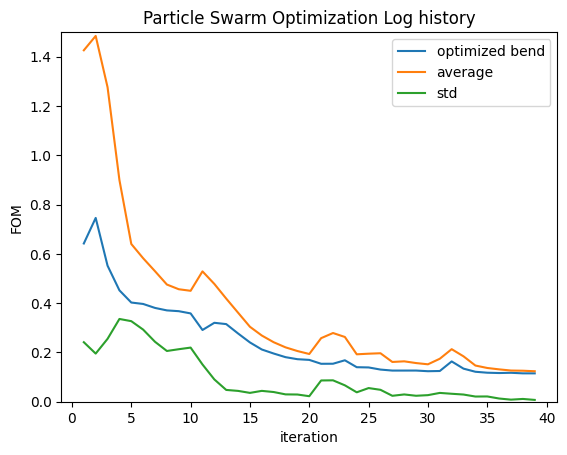

In [17]:
iter_nums = np.linspace(1, len(log_history), len(log_history))
plot_cut_iter_num_start = 0
plot_cut_iter_num_end= -1

plt.plot(iter_nums[plot_cut_iter_num_start:plot_cut_iter_num_end], log_history[plot_cut_iter_num_start:plot_cut_iter_num_end], label="optimized bend")
plt.plot(iter_nums[plot_cut_iter_num_start:plot_cut_iter_num_end], avg_history[plot_cut_iter_num_start:plot_cut_iter_num_end], label="average")
plt.plot(iter_nums[plot_cut_iter_num_start:plot_cut_iter_num_end], std_history[plot_cut_iter_num_start:plot_cut_iter_num_end], label="std")
plt.xlabel("iteration")
plt.ylabel("FOM")
plt.ylim(0,1.5)
plt.title("Particle Swarm Optimization Log history")
plt.legend()

#### Optimized Structure Shape

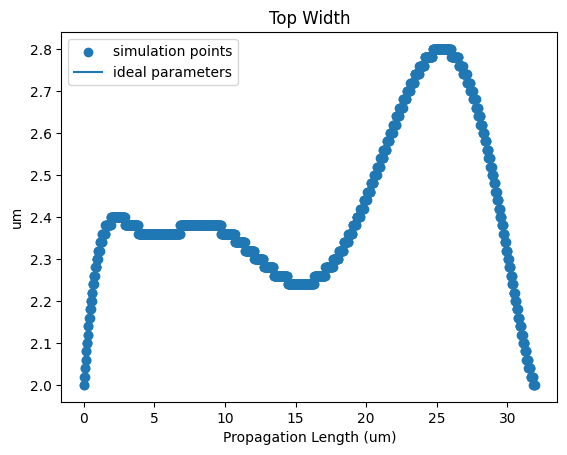

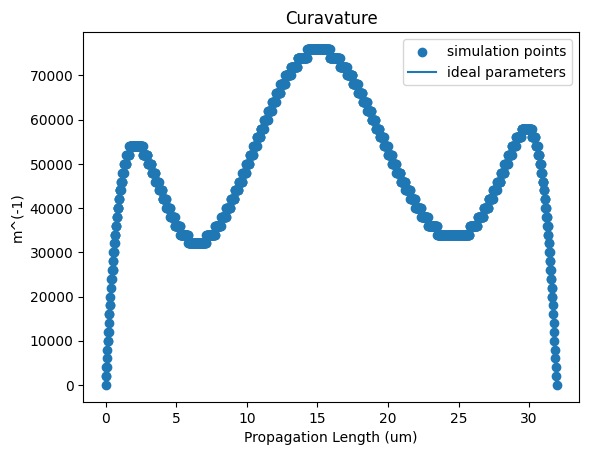

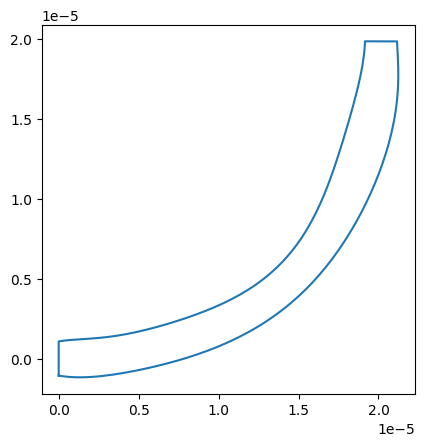

(array([6.54389478e-23, 3.28949903e-07, 6.63001817e-07, 1.00276640e-06,
        1.34649993e-06, 1.69262185e-06, 2.03981318e-06, 2.38704277e-06,
        2.73355235e-06, 3.07882067e-06, 3.42252006e-06, 3.76447297e-06,
        4.10461303e-06, 4.44295227e-06, 4.77955486e-06, 5.11451694e-06,
        5.44795157e-06, 5.77997766e-06, 6.11071200e-06, 6.44026345e-06,
        6.76872858e-06, 7.09618841e-06, 7.42270569e-06, 7.74832265e-06,
        8.07305918e-06, 8.39691115e-06, 8.71984916e-06, 9.04181763e-06,
        9.36273426e-06, 9.68248991e-06, 1.00009490e-05, 1.03179506e-05,
        1.06333095e-05, 1.09468184e-05, 1.12582502e-05, 1.15673608e-05,
        1.18738927e-05, 1.21775778e-05, 1.24781421e-05, 1.27753088e-05,
        1.30688029e-05, 1.33583552e-05, 1.36437058e-05, 1.39246082e-05,
        1.42008327e-05, 1.44721689e-05, 1.47384291e-05, 1.49994497e-05,
        1.52550930e-05, 1.55052481e-05, 1.57498309e-05, 1.59887841e-05,
        1.62220765e-05, 1.64497010e-05, 1.66716729e-05, 1.688802

In [18]:
input_width = 2e-6
output_width = 2e-6
min_width = 2e-6
max_width = 3e-6
param_length = len(best)//2
width_params = best[:param_length]
curvature_params = best[param_length:]
Rx = 20e-6
Ry = 20e-6
optimized_bend = generate_smooth_bend(input_width, output_width, min_width, max_width, width_params, curvature_params, Rx, Ry, resolution = 100)
optimized_bend.plot_structure_parameters()
optimized_bend.plot_2D_structure()


#### Optimized Structure Performance

{'prop_lengths': array([0.00000000e+00, 1.91824880e-02, 2.55766506e-02, ...,
        3.18876892e+01, 3.19196600e+01, 3.19516308e+01], shape=(1432,)),
 'mode1': array([0.        , 0.        , 0.00066244, ..., 0.4127925 , 0.43274626,
        0.45293128], shape=(1432,)),
 'mode2': array([1.        , 1.        , 0.99909621, ..., 0.50410378, 0.47977948,
        0.45510158], shape=(1432,)),
 'mode3': array([0.        , 0.        , 0.00024115, ..., 0.04473849, 0.04840313,
        0.05216301], shape=(1432,)),
 'mode4': array([0.00000000e+00, 0.00000000e+00, 3.80349752e-09, ...,
        2.92618833e-02, 3.00831329e-02, 3.09397653e-02], shape=(1432,)),
 'mode5': array([0.00000000e+00, 0.00000000e+00, 8.78269901e-08, ...,
        8.29679798e-03, 8.17835983e-03, 8.05042870e-03], shape=(1432,)),
 'mode6': array([0.00000000e+00, 0.00000000e+00, 5.70972998e-17, ...,
        9.45347897e-11, 9.23152596e-11, 8.95173241e-11], shape=(1432,)),
 'mode7': array([0.00000000e+00, 0.00000000e+00, 1.93612290e-16,

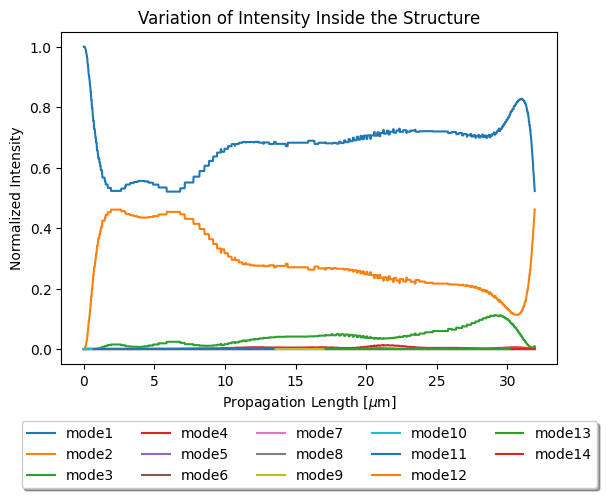

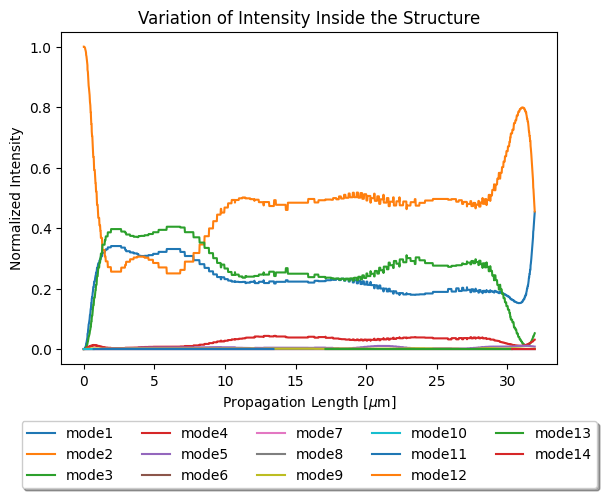

In [19]:
optimized_bend_eme = sim.EME(optimized_bend, force_unitary=1)
optimized_bend_eme_runner = sim.Runner(optimized_bend_eme)
optimized_bend_eme_runner.propagate([1,0,0,0,0,0,0,0,0,0])
optimized_bend_eme_runner.plot_intensity_along_propagation()
optimized_bend_eme_runner.propagate([0,1,0,0,0,0,0,0,0,0])
optimized_bend_eme_runner.plot_intensity_along_propagation()